In [ ]:
# pip install -U numpy pandas scikit-learn matplotlib joblib scipy

# Explore full dataset

In [53]:
full_df = pd.read_csv("../../Kmer-Memory-Predict/input/mgnify_assemblies_stats.csv")

In [54]:
full_df.head()

,primary_accession,lineage,assembler,assembler_version,wall_clock_seconds,peak_mem_in_gbs,n50,l50,num_contigs,assembly_length,largest_contig
0,ERZ504995,root:Host-associated:Mammals:Digestive system:...,metaspades,3.11.1,79577,84,9249,34933,44181,54010522,41720
1,ERZ504996,root:Host-associated:Mammals:Digestive system:...,metaspades,3.11.1,139901,135,4856,12191,17046,31365221,71860
2,ERZ504999,root:Host-associated:Mammals:Digestive system:...,metaspades,3.11.1,48294,56,642,1479,2120,3791370,12530
3,ERZ484593,root:Environmental:Aquatic:Marine:Oceanic,metaspades,3.11.1,28744,34,681,1859,2539,4642335,15741
4,ERZ484596,root:Environmental:Aquatic:Marine:Oceanic,metaspades,3.11.1,18560,20,815,1789,2603,4819991,8829


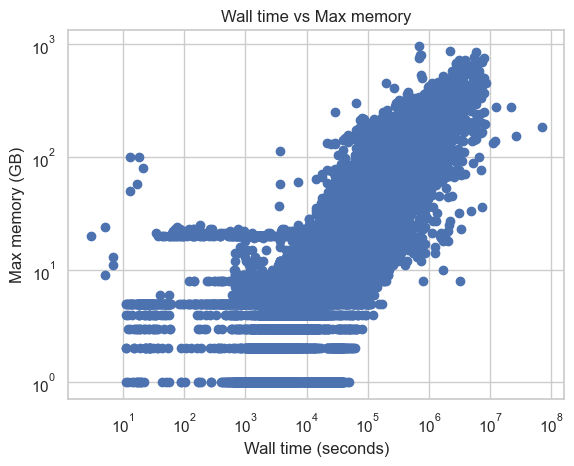

In [31]:
# Investigate if wall clock time is correlated with memory usage. make plot with log scales
import matplotlib.pyplot as plt
plt.scatter(full_df['wall_clock_seconds'], full_df['peak_mem_in_gbs'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wall time (seconds)')
plt.ylabel('Max memory (GB)')
plt.title('Wall time vs Max memory')
plt.show()


In [ ]:
# Check how bad is change in 0.0.X versions of SPAdes

In [ ]:
for g,gr in full_df.groupby('spades_version'):
    print(g, gr['peak_mem_in_gbs'].describe())

In [2]:

# Cell 1 — imports & config
from __future__ import annotations

import math
import json
import pathlib
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict, Any

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, ConstantKernel
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.stats import norm

# 2) Data assumptions & utilities

Replace the `load_your_data()` stub with your actual data loading. We assume:

* a DataFrame with feature columns (mixed numeric/categorical ok),
* a target column named `max_memory_used` in **GB** (change as needed).



In [3]:
TARGET_COL = "peak_mem_in_gbs"   # change to match your dataset
JOB_ID_COL = "primary_accession"                # optional: if you have job IDs
GROUP_COL = None                 # optional: grouping for CV (e.g., user/project)

def load_your_data() -> pd.DataFrame:
    df = pd.read_csv("../../Kmer-Memory-Predict/updated_mgnify_assemblies_stats_v3.15.3_metaspades_kmer_stats.csv", index_col=0)
    y_df = pd.read_csv("../../Kmer-Memory-Predict/input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv", sep=",")
    y_dict = dict(zip(y_df['srr_id'], y_df[TARGET_COL]))
    df[TARGET_COL] = df.index.map(y_dict)

    # drop 'mcintosh_e' column due to high missingness
    df = df.drop(columns=['mcintosh_e'])
    
    return df

def infer_feature_types(df: pd.DataFrame, target_col: str) -> Tuple[List[str], List[str]]:
    """Infer numeric vs categorical columns (simple heuristic)."""
    feats = [c for c in df.columns if c != target_col]
    num_cols, cat_cols = [], []
    for c in feats:
        if pd.api.types.is_numeric_dtype(df[c]):
            num_cols.append(c)
        else:
            cat_cols.append(c)
    return num_cols, cat_cols

# 3) Preprocessing pipeline

Key decisions:

* **Scale numeric** features (GP kernels assume comparable length scales).
* **One-hot encode** categoricals (sparse → dense inside GPR is fine for moderate cardinality).
* **(Optional) log-transform** `y` if memory is strictly positive and heavy-tailed → improves Gaussianity.
  We implement both modes and let you switch with `log_target=True`.


In [4]:
@dataclass
class TargetTransform:
    log_target: bool = True
    clip_min: Optional[float] = 1e-6  # avoid log(0)
    
    def transform(self, y: np.ndarray) -> np.ndarray:
        y = np.asarray(y, dtype=float)
        if self.log_target:
            y = np.maximum(y, self.clip_min if self.clip_min is not None else 0.0)
            return np.log(y)
        return y
    
    def inverse(self, y_trans: np.ndarray) -> np.ndarray:
        if self.log_target:
            return np.exp(y_trans)
        return y_trans


def build_preprocessor(df: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    num_cols, cat_cols = infer_feature_types(df, TARGET_COL)
    numeric = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True))
    ])
    categorical = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    pre = ColumnTransformer(
        transformers=[
            ("num", numeric, num_cols),
            ("cat", categorical, cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )
    return pre, num_cols, cat_cols


# 4) Kernel design for GPR

Key decisions:

* Start with: **Constant** × (RBF + DotProduct) + **WhiteKernel**

  * `RBF` captures smooth nonlinearities with length-scales per feature (ARD).
  * `DotProduct` adds a linear trend.
  * `WhiteKernel` models noise.
* **Bounds** matter: set conservative but not too wide; too wide → slow/unstable; too tight → underfit.



In [5]:

def make_kernel(n_features: int) -> Any:
    """
    ARD RBF + linear, scaled by a Constant, plus noise.
    Length_scale bounds roughly [1e-2, 1e2] after StandardScaler.
    """
    rbf = RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-2, 1e2))
    linear = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-3, 1e3))
    core = rbf + linear
    kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)) * core
    noise = WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))
    return kernel + noise



# 5) A lightweight GP model wrapper

This class:

* builds the preprocessing + GPR pipeline,
* fits/serializes,
* predicts **mean & std** in the **original target space**,
* returns **quantiles** for safe allocation (e.g., 0.95).


In [6]:


class GPRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        log_target: bool = True,
        alpha: float = 1e-10,              # jitter for GPR stability (not noise)
        n_restarts_optimizer: int = 2,     # bump up if kernel opt gets stuck (trade-off: slower)
        normalize_y: bool = False,         # we handle target transform ourselves
        random_state: Optional[int] = 42,
    ):
        self.log_target = log_target
        self.alpha = alpha
        self.n_restarts_optimizer = n_restarts_optimizer
        self.normalize_y = normalize_y
        self.random_state = random_state
        
        self.tt = TargetTransform(log_target=log_target)
        self.pipeline_: Optional[Pipeline] = None
        self.feature_names_out_: Optional[List[str]] = None

    def _make_pipeline(self, X_df: pd.DataFrame) -> Pipeline:
        pre, num_cols, cat_cols = build_preprocessor(pd.concat([X_df, pd.Series(dtype=float, name=TARGET_COL)], axis=1))
        # We need n_features AFTER preprocessing to build ARD kernel
        # Make a temporary fit to get transformed feature count.
        pre_fit = clone(pre).fit(X_df)
        X_tmp = pre_fit.transform(X_df.iloc[:1])
        n_features = X_tmp.shape[1]
        kernel = make_kernel(n_features)
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            alpha=self.alpha,
            n_restarts_optimizer=self.n_restarts_optimizer,
            normalize_y=self.normalize_y,
            random_state=self.random_state,
        )
        pipe = Pipeline(steps=[("pre", pre_fit), ("gpr", gpr)])
        # store feature names for introspection
        try:
            self.feature_names_out_ = pre_fit.get_feature_names_out().tolist()
        except Exception:
            self.feature_names_out_ = None
        return pipe

    def fit(self, X: pd.DataFrame, y: np.ndarray):
        y_t = self.tt.transform(y)
        self.pipeline_ = self._make_pipeline(X)
        self.pipeline_.fit(X, y_t)
        return self

    def predict_distribution(self, X: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Returns predictive mean and std in ORIGINAL target space.
        Uses delta-method for log-target to transform mean/std.
        """
        assert self.pipeline_ is not None, "Model not fitted."
        # Get predictions in transformed space
        mean_t, std_t = self.pipeline_["gpr"].predict(self.pipeline_["pre"].transform(X), return_std=True)
        if self.log_target:
            # If Y = exp(Y_t), then E[Y] ≈ exp(mu + 0.5*sigma^2); Var[Y] ≈ (exp(sigma^2)-1)*exp(2mu+sigma^2)
            exp_term = np.exp(std_t**2)
            mean = np.exp(mean_t + 0.5 * std_t**2)
            var = (exp_term - 1.0) * np.exp(2.0 * mean_t + std_t**2)
            std = np.sqrt(var)
            return mean, std
        else:
            return mean_t, std_t

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        mean, _ = self.predict_distribution(X)
        return mean

    def predict_quantile(self, X: pd.DataFrame, q: float = 0.95) -> np.ndarray:
        """
        Gaussian assumption in transformed space; map quantile to original space.
        For log-target, Quantile(Y) = exp( mu_t + z_q * sigma_t ).
        For linear target, Quantile(Y) = mu + z_q * sigma.
        """
        assert 0.0 < q < 1.0
        z = z = norm.ppf(q)  # inverse CDF of standard normal
        pre = self.pipeline_["pre"]
        gpr = self.pipeline_["gpr"]
        mu_t, sigma_t = gpr.predict(pre.transform(X), return_std=True)
        if self.log_target:
            return np.exp(mu_t + z * sigma_t)
        else:
            return mu_t + z * sigma_t

    def save(self, path: str | pathlib.Path):
        assert self.pipeline_ is not None
        blob = {
            "pipeline": self.pipeline_,
            "log_target": self.log_target,
        }
        joblib.dump(blob, path)

    @classmethod
    def load(cls, path: str | pathlib.Path) -> "GPRegressorWrapper":
        blob = joblib.load(path)
        model = cls(log_target=blob["log_target"])
        model.pipeline_ = blob["pipeline"]
        return model



# 6) Cross-validation & model selection

We’ll:

* evaluate **MAE**, **RMSE**, and **coverage** (how often the chosen quantile actually covers the true value),
* allow either `KFold` or `GroupKFold` (if you have `GROUP_COL` to prevent leakage).

**Key parameter to tune:** kernel complexity (we keep fixed), `n_restarts_optimizer`, and whether to `log_target`.
For bigger datasets, you may also downsample or consider sparse GP libraries — see notes at the end.


In [7]:

@dataclass
class CVConfig:
    n_splits: int = 5
    shuffle: bool = True
    random_state: int = 42
    quantile_for_safety: float = 0.95

def coverage_at_quantile(y_true: np.ndarray, y_q: np.ndarray) -> float:
    """Fraction of times y_true <= y_q."""
    return float(np.mean(y_true <= y_q))

def run_cv(
    df: pd.DataFrame,
    log_target: bool = True,
    group_col: Optional[str] = GROUP_COL,
    cfg: CVConfig = CVConfig()
) -> Dict[str, Any]:
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL].to_numpy(dtype=float)
    groups = df[group_col].to_numpy() if group_col is not None else None

    splitter = (GroupKFold(n_splits=cfg.n_splits) if groups is not None
                else KFold(n_splits=cfg.n_splits, shuffle=cfg.shuffle, random_state=cfg.random_state))

    metrics = []
    for fold, (tr, va) in enumerate(splitter.split(X, y, groups=groups), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y[tr], y[va]
        model = GPRegressorWrapper(log_target=log_target, n_restarts_optimizer=2)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_va)
        y_q = model.predict_quantile(X_va, q=cfg.quantile_for_safety)

        fold_metrics = {
            "fold": fold,
            "MAE": mean_absolute_error(y_va, y_pred),
            "RMSE": math.sqrt(mean_squared_error(y_va, y_pred)),
            "Coverage@q": coverage_at_quantile(y_va, y_q),
        }
        metrics.append(fold_metrics)
        print(f"[Fold {fold}] MAE={fold_metrics['MAE']:.3f}  RMSE={fold_metrics['RMSE']:.3f}  "
              f"Coverage@{cfg.quantile_for_safety:.2f}={fold_metrics['Coverage@q']:.3f}")

    df_metrics = pd.DataFrame(metrics)
    print("\nCV summary:\n", df_metrics.describe().T)
    return {"per_fold": df_metrics, "summary": df_metrics.describe().T.to_dict()}


# 7) Training on full data + saving the model

**Key decisions:**

* Set `log_target=True` if target is positive & skewed (typical for memory).
* Increase `n_restarts_optimizer` if the kernel fit seems poor or unstable (but training slows down).


In [8]:

def train_and_save(df: pd.DataFrame, out_path: str = "gp_memory_model.joblib", log_target: bool = True) -> GPRegressorWrapper:
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL].to_numpy(dtype=float)
    model = GPRegressorWrapper(log_target=log_target, n_restarts_optimizer=5)
    model.fit(X, y)
    model.save(out_path)
    print(f"Saved model to: {out_path}")
    return model



# 8) Inference helpers: safe allocation & post-hoc calibration

We expose:

* `predict_safe_allocation` → pick quantile (e.g., 0.95 or 0.99),
* optional **post-hoc calibration** of quantiles (simple multiplicative safety factor learned from a validation set to hit desired coverage).


In [9]:

def predict_safe_allocation(
    model: GPRegressorWrapper,
    X_new: pd.DataFrame,
    quantile: float = 0.95,
    min_mem_gb: Optional[float] = None,
    max_mem_gb: Optional[float] = None,
) -> pd.Series:
    q_pred = model.predict_quantile(X_new, q=quantile)
    if min_mem_gb is not None:
        q_pred = np.maximum(q_pred, min_mem_gb)
    if max_mem_gb is not None:
        q_pred = np.minimum(q_pred, max_mem_gb)
    return pd.Series(q_pred, index=X_new.index, name=f"safe_mem_q{int(quantile*100)}_GB")


def learn_safety_factor(
    model: GPRegressorWrapper,
    X_val: pd.DataFrame,
    y_val: np.ndarray,
    quantile: float = 0.95,
) -> float:
    """
    Learn multiplicative factor 'k' such that P(y_true <= k * q_pred) ≈ quantile.
    Useful if predictive intervals are under/over-confident in practice.
    """
    q_pred = model.predict_quantile(X_val, q=quantile)
    # grid search on simple scale factors
    candidates = np.linspace(0.8, 1.3, 51)
    best_k, best_err = 1.0, 1e9
    for k in candidates:
        cov = coverage_at_quantile(y_val, k * q_pred)
        err = abs(cov - quantile)
        if err < best_err:
            best_err, best_k = err, k
    print(f"Calibrated safety factor k={best_k:.3f} (coverage error={best_err:.3f})")
    return float(best_k)


# 9) End-to-end example (wire it all together)

This cell shows a typical flow once you implement `load_your_data()`.


In [10]:
df = load_your_data()

# remove outliers for peak_memory and file_size (keep 95th percentile)
df = df[df["peak_mem_in_gbs"] <= df["peak_mem_in_gbs"].quantile(0.95)]
df = df[df["file_size"] <= df["file_size"].quantile(0.95)]


In [11]:

# quick train/val split for calibration & sanity check
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print("Train/Val shapes:", train_df.shape, val_df.shape)


Train/Val shapes: (212, 40) (54, 40)


In [ ]:

# 1) Cross-validation to decide on log_target & basic health check
print("\n=== CV (log_target=True) ===")
_ = run_cv(train_df, log_target=True, cfg=CVConfig(n_splits=5, quantile_for_safety=0.95))
print("\n=== CV (log_target=False) ===")
_ = run_cv(train_df, log_target=False, cfg=CVConfig(n_splits=5, quantile_for_safety=0.95))
"""
=== CV (log_target=True) ===
CV summary:
             count          mean           std        min        25%  \
fold          5.0  3.000000e+00  1.581139e+00   1.000000   2.000000   
MAE           5.0  1.338009e+27  2.991879e+27  27.229923  32.178409   
RMSE          5.0  8.671288e+27  1.938959e+28  51.634331  52.086949   
Coverage@q    5.0  9.199336e-01  5.851485e-02   0.837209   0.880952   

                   50%          75%           max  
fold          3.000000     4.000000  5.000000e+00  
MAE          83.969576   627.553713  6.690044e+27  
RMSE        360.200196  3059.133308  4.335644e+28  
Coverage@q    0.952381     0.952381  9.767442e-01 

=== CV (log_target=False) ===

CV summary:
             count       mean        std        min        25%        50%  \
fold          5.0   3.000000   1.581139   1.000000   2.000000   3.000000   
MAE           5.0  31.713403   7.582166  24.126888  26.291548  28.966057   
RMSE          5.0  47.479956  20.911589  33.411636  36.277236  37.090798   
Coverage@q    5.0   0.844629   0.041424   0.790698   0.833333   0.837209   

                  75%        max  
fold         4.000000   5.000000  
MAE         37.210496  41.972025  
RMSE        46.843870  83.776243  
Coverage@q   0.857143   0.904762 
"""
# Choose best (usually log_target=True for memory)


In [12]:
chosen_log = False

In [ ]:

# 2) Train full model on training split and save
model = train_and_save(train_df, out_path="gp_memory_model.joblib", log_target=chosen_log)

# 3) Evaluate on validation split
X_val = val_df.drop(columns=[TARGET_COL])
y_val = val_df[TARGET_COL].to_numpy(float)
y_pred_mean = model.predict(X_val)
y_pred_q95  = model.predict_quantile(X_val, q=0.95)
print("Val MAE:", mean_absolute_error(y_val, y_pred_mean))
print("Val RMSE:", math.sqrt(mean_squared_error(y_val, y_pred_mean)))
print("Val Coverage@0.95:", coverage_at_quantile(y_val, y_pred_q95))
"""
Saved model to: gp_memory_model.joblib
Val MAE: 29.87
Val RMSE: 42.62
Val Coverage@0.95: 0.814
"""


In [89]:

# Optional: learn a multiplicative safety factor (post-hoc calibration)
k = learn_safety_factor(model, X_val, y_val, quantile=0.95)


Calibrated safety factor k=1.260 (coverage error=0.006)


In [ ]:

# 4) Deploy: safe allocation for new jobs (with calibrated factor)
# X_new = pd.DataFrame([...])  # your incoming jobs
# q95 = model.predict_quantile(X_new, q=0.95) * k
# safe_alloc = np.clip(q95, 4.0, None)  # enforce minimum e.g. 4.0 GB
# print(pd.Series(safe_alloc, name="safe_memory_gb"))



# 10) Quick diagnostics (optional)

1. **Kernel printout** after fit tells you what length-scales/noise were learned.
2. **Reliability diagram** for quantiles: does q=0.95 actually give ~95% coverage?


In [13]:
def print_kernel(model: GPRegressorWrapper):
    gpr = model.pipeline_["gpr"]
    print("Learned kernel:\n", gpr.kernel_)

def quantile_reliability_curve(model: GPRegressorWrapper, X: pd.DataFrame, y: np.ndarray, qs=None):
    if qs is None:
        qs = np.linspace(0.5, 0.99, 10)
    coverages = []
    for q in qs:
        y_q = model.predict_quantile(X, q=q)
        coverages.append(coverage_at_quantile(y, y_q))
    plt.figure()
    plt.plot(qs, coverages, marker="o", label="empirical coverage")
    plt.plot([0,1],[0,1], linestyle="--", label="ideal")
    plt.xlabel("Target quantile (q)")
    plt.ylabel("Empirical coverage")
    plt.title("Quantile reliability")
    plt.legend()
    plt.show()


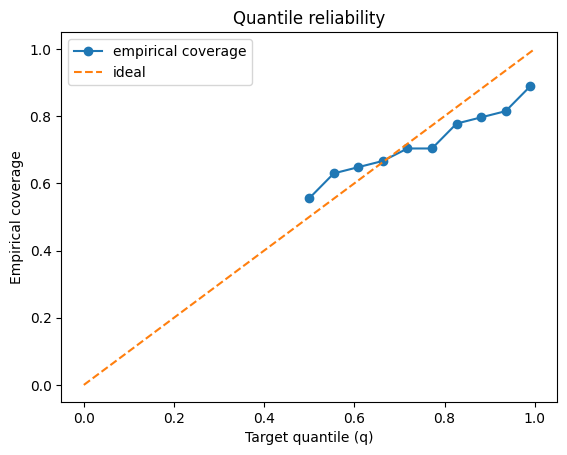

In [92]:
quantile_reliability_curve(model, X_val, y_val)

## How to set key parameters (practical advice)

* **`log_target`**:

  * If memory is strictly positive and skewed (common), set `True`.
  * Check which setting yields better CV metrics and more reliable coverage.

* **Kernel & bounds**:

  * Start with the provided kernel. The ARD RBF length-scales should be in a reasonable range if features are standardized. If you see absurd values (e.g., all length-scales pegged at upper bound), consider widening bounds or revisiting scaling / feature leakage.
  * If you have many weakly relevant categoricals (after one-hot), consider manual feature selection or embedding them before GP.

* **`WhiteKernel` noise level**:

  * If it pegs at large values, model might be underfitting; consider richer features or try `log_target=False` briefly.
  * If it pegs at tiny values with poor generalization, you may be overfitting.

* **`alpha` (jitter)**:

  * Keep a small `alpha` (1e-10 to 1e-6). Increase if you get numerical warnings (ill-conditioned matrix).

* **`n_restarts_optimizer`**:

  * 2–10. More restarts → better kernel hyperparams, slower training.

* **Cross-validation**:

  * Use `GroupKFold` when jobs from the same user/project appear in both train and val (prevents optimistic leakage).
  * Track **Coverage@q** along with MAE/RMSE; your use-case cares about **upper-tail** correctness.

* **Quantile for safety**:

  * Typical: 0.95 or 0.99 depending on how costly failures are. Validate empirically.
  * Consider the **post-hoc safety factor** `k` to hit your desired SLA coverage with minimal over-allocation.

* **Scaling to larger datasets (> ~10k rows)**:

  * `GaussianProcessRegressor` scales as O(n³). If training becomes slow:

    * Subsample intelligently (e.g., stratified by target quantiles).
    * Use **local GPs** or **inducing-point / sparse GPs** (e.g., GPyTorch).
      The rest of this pipeline still applies (preprocessing, calibration).

---

## Deployment notes

* Save the entire pipeline (`model.save(...)`) so preprocessing is identical at inference time.
* Build a thin wrapper around `predict_safe_allocation()` with your chosen `quantile` and optional calibrated factor `k`, plus min/max guards (e.g., min 0.5 GB, cap at node limit).
* Log predictions, chosen quantiles, and whether the job succeeded without OOM to continuously **monitor & recalibrate**.

---

If you paste in a sample of your actual schema (column names/types) I can tailor the `load_your_data()` and suggest reasonable feature engineering (e.g., log of input size, counts, categorical embeddings) to improve both accuracy and interval reliability.


# Compare with RandomForest models

In [14]:
#!/usr/bin/env python3
"""
Run Random Forest on k-mer stats and plot trade-off between underpredicted samples
and excess memory across several models (including Random Forest).

Usage:
  python run_rf_tradeoff.py \
    --stats-csv updated_mgnify_assemblies_stats_v3.15.3_metaspades_kmer_stats.csv \
    --meta-csv input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv \
    --output plot_tradeoff.png

Assumes the stats CSV was exported with sample IDs as the index (first column).
"""

import argparse
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_predict

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

sns.set(style="whitegrid")


def load_stats(stats_path: Path) -> pd.DataFrame:
    # try load with first column as index (common when saving DataFrame.to_csv())
    df = pd.read_csv(stats_path, index_col=0)
    # ensure numeric columns only (drop metrics that are non-numeric)
    df = df.apply(pd.to_numeric, errors="coerce")
    return df


def load_metadata(meta_path: Path) -> pd.DataFrame:
    df = pd.read_csv(meta_path)
    # try common names
    if "srr_id" in df.columns and "peak_mem_in_gbs" in df.columns:
        df2 = df.set_index("srr_id")[["peak_mem_in_gbs"]]
        return df2

    # fallback: try to find the best column names
    candidates = [c for c in df.columns if "srr" in c.lower() or "run" in c.lower()]
    mem_cols = [c for c in df.columns if "mem" in c.lower() or "peak" in c.lower()]
    if candidates and mem_cols:
        idx_col = candidates[0]
        mem_col = mem_cols[0]
        return df.set_index(idx_col)[[mem_col]].rename(columns={mem_col: "peak_mem_in_gbs"})

    raise ValueError("Could not find 'srr_id' and 'peak_mem_in_gbs' columns in metadata."
                     " Please provide a metadata CSV with these columns.")


def compute_tradeoff(y_true: np.ndarray, y_pred_base: np.ndarray, adjustment_steps: np.ndarray):
    underpred_percent_list = []
    excess_memory_list = []
    n_samples = len(y_true)

    for adj in adjustment_steps:
        y_pred_adj = y_pred_base + adj
        under_pred_mask = y_pred_adj < y_true
        under_pred_count = np.sum(under_pred_mask)
        under_pred_percent = (under_pred_count / n_samples) * 100

        # for samples where prediction >= true, compute excess memory
        excess_memory = y_pred_adj[~under_pred_mask] - y_true[~under_pred_mask]
        total_excess_memory = np.sum(excess_memory)

        underpred_percent_list.append(under_pred_percent)
        excess_memory_list.append(total_excess_memory)

    return np.array(underpred_percent_list), np.array(excess_memory_list)



In [15]:
p = argparse.ArgumentParser()

p.add_argument("--output", default="tradeoff_models.png", help="Output plot file (PNG)")
p.add_argument("--adjust-min", type=float, default=-100.0, help="Min adjustment (GB)")
p.add_argument("--adjust-max", type=float, default=100.0, help="Max adjustment (GB)")
p.add_argument("--adjust-step", type=float, default=5.0, help="Adjustment step (GB)")
args = p.parse_args([])


In [16]:

df = load_your_data()

df = df.fillna(0)
# remove outliers for peak_memory and file_size (keep 95th percentile)
df = df[df["peak_mem_in_gbs"] <= df["peak_mem_in_gbs"].quantile(0.95)]
df = df[df["file_size"] <= df["file_size"].quantile(0.95)]

stats = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

features_all = stats.columns.tolist()


In [ ]:
k=1.2

# build model list
models = [
    ("Model 4: All features (Random Forest)", features_all, RandomForestRegressor(random_state=42)),
]


adjustment_steps = np.arange(args.adjust_min, args.adjust_max + 0.0001, args.adjust_step)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(12, 8))

y_pred_base = np.empty_like(y)
y_pred_mean = np.empty_like(y)
# y_pred_p95 = np.empty_like(y)
# y_pred_p95_corrected = np.empty_like(y)

quant_results = {}
quantiles = [0.75,0.8,0.85, 0.9, 0.95, 0.99, 0.995, 0.9999, 0.99999]

ks= []
# iterate through folds
for train_idx, test_idx in cv.split(stats, y):
    x_train,y_train = stats.iloc[train_idx], y[train_idx]
    x_test,y_test = stats.iloc[test_idx],y[test_idx]
    title, feat_list, model = models[0]
    model.fit(x_train,y_train)
    preds = model.predict(x_test)
    y_pred_base[test_idx] = preds   # <--- this is the key step


    ## BAYES
    model = train_and_save(df.iloc[train_idx], out_path=f"gp_memory_model_{train_idx[0]}.joblib", log_target=chosen_log)

    # 3) Evaluate on validation split
    X_val = df.iloc[test_idx].drop(columns=[TARGET_COL])
    y_val = df.iloc[test_idx][TARGET_COL].to_numpy(float)
    _y_pred_mean = model.predict(X_val)
    # _y_pred_p95  = model.predict_quantile(X_val, q=0.95)



    # y_pred_mean[test_idx] = _y_pred_mean
    # y_pred_p95[test_idx] = _y_pred_p95
    # y_pred_p95_corrected[test_idx] = _y_pred_p95 * k

    _k = learn_safety_factor(model, X_val, y_val, quantile=0.95)

    for _q in quantiles:
        _y_q = model.predict_quantile(X_val, q=_q)
        quant_results.setdefault(_q, np.empty_like(y))[test_idx]  = _y_q
        quant_results.setdefault(f"{_q}_corrected", np.empty_like(y))[test_idx]  = _y_q * k
    ks.append(_k)


Random Forest [99.62406015 99.62406015 99.62406015 99.2481203  98.4962406  97.36842105
 95.86466165 93.98496241 92.10526316 92.10526316 91.35338346 89.84962406
 88.72180451 86.09022556 81.20300752 79.69924812 75.18796992 69.54887218
 65.41353383 61.65413534 44.73684211 31.57894737 27.81954887 25.93984962
 22.18045113 19.92481203 16.54135338 15.41353383 12.40601504 10.52631579
  9.39849624  8.27067669  7.51879699  6.39097744  5.26315789  4.13533835
  3.0075188   2.63157895  2.63157895  2.2556391   1.5037594 ] [1.4000e+01 1.9000e+01 2.4000e+01 3.0000e+01 4.3000e+01 7.1000e+01
 1.1700e+02 1.8000e+02 2.6500e+02 3.7000e+02 4.7800e+02 6.0100e+02
 7.4300e+02 9.0100e+02 1.1000e+03 1.3590e+03 1.6550e+03 2.0110e+03
 2.4330e+03 2.9100e+03 3.4890e+03 4.3150e+03 5.2380e+03 6.2150e+03
 7.2240e+03 8.2740e+03 9.3500e+03 1.0471e+04 1.1614e+04 1.2788e+04
 1.3981e+04 1.5188e+04 1.6412e+04 1.7652e+04 1.8903e+04 2.0163e+04
 2.1448e+04 2.2741e+04 2.4036e+04 2.5334e+04 2.6637e+04]
Saved trade-off plot to: tr

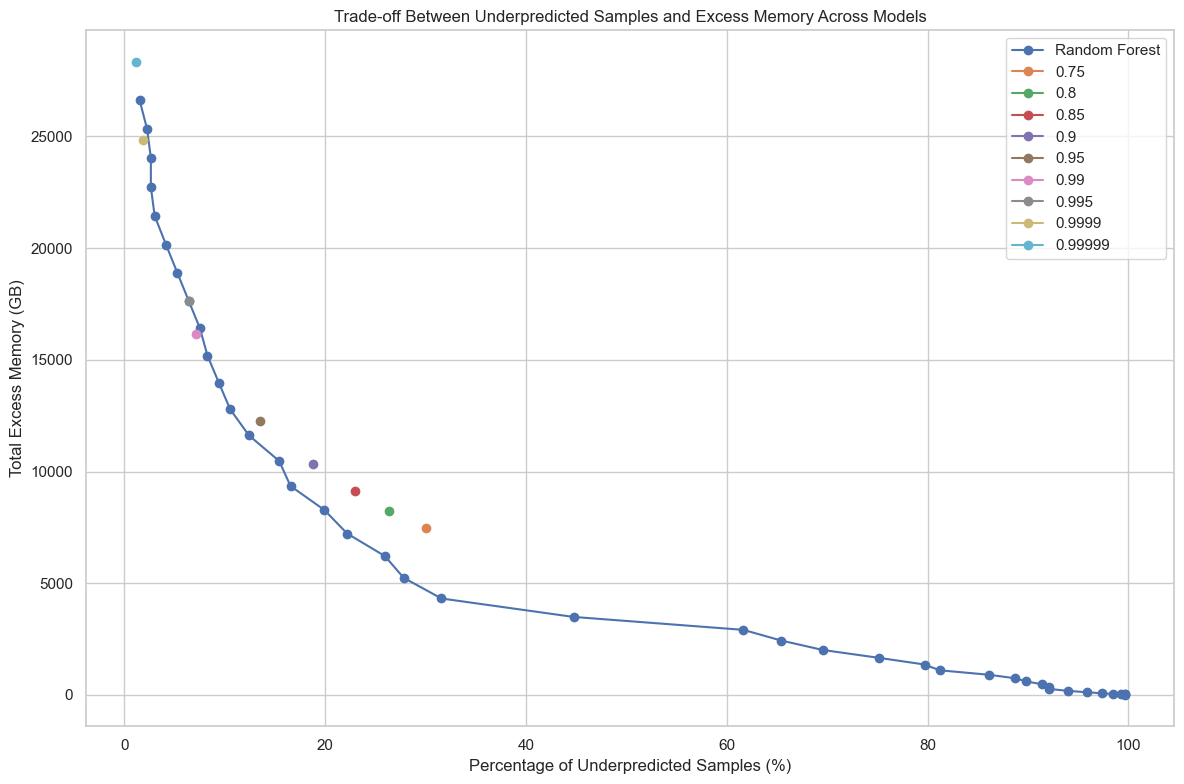

In [ ]:
plt.figure(figsize=(12, 8))

_adjustment_steps  = [0]
## Plot random forest
for _y_pred , title in [
    (y_pred_base, "Random Forest"),
    # (y_pred_mean, "Gaussian Process (mean)"),
    # (y_pred_p95, "Gaussian Process (p95)"),
    # (y_pred_p95_corrected, f"Gaussian Process (p95 * correction({k})"),
]:
    underpred_percent_list, excess_memory_list = compute_tradeoff(y, _y_pred, adjustment_steps)
    # print(title, underpred_percent_list, excess_memory_list)
    plt.plot(underpred_percent_list, excess_memory_list, label=title, marker='o')

for title,_y_pred in quant_results.items():
    if "corre" in str(title):
        continue
    underpred_percent_list, excess_memory_list = compute_tradeoff(y, _y_pred, _adjustment_steps)
    plt.plot(underpred_percent_list, excess_memory_list, label=title, marker='o')




plt.xlabel("Percentage of Underpredicted Samples (%)")
plt.ylabel("Total Excess Memory (GB)")
plt.title("Trade-off Between Underpredicted Samples and Excess Memory Across Models")
plt.legend()
plt.grid(True)
# plt.xlim(0, 40)
# auto-ylim but keep a reasonable lower bound
# plt.ylim(bottom=0)

out_path = Path(args.output)
plt.tight_layout()
# plt.savefig(out_path, dpi=150)
# print(f"Saved trade-off plot to: {out_path}")


# close figure
plt.show()
plt.close()



In [ ]:
# 

In [143]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def coverage_at_quantile(y_true, y_q):
    return float(np.mean(y_true <= y_q))

def failure_rate(y_true, y_safe):
    """Jobs that would OOM (allocation below actual). Lower is better."""
    return float(np.mean(y_safe < y_true))

def overallocation(y_true, y_safe):
    """Mean relative overallocation. Lower is better (but must balance failure rate)."""
    rel = (y_safe - y_true) / np.clip(y_true, 4, None)
    return float(np.mean(rel))

def nll_gaussian(y_true, mu, sigma):
    """Average negative log-likelihood assuming Gaussian predictive (per sample)."""
    sigma = np.clip(sigma, 4, None)
    # -log N(y; mu, sigma^2) = 0.5*log(2π) + log(sigma) + 0.5*((y-mu)/sigma)^2
    term = 0.5*np.log(2*np.pi) + np.log(sigma) + 0.5*((y_true - mu)/sigma)**2
    return float(np.mean(term))

def evaluate_at_quantile(model, X, y, q=0.95):
    y_mean, y_std = model.predict_distribution(X)
    y_q = model.predict_quantile(X, q=q)
    metrics = {
        "MAE": mean_absolute_error(y, y_mean),
        "RMSE": root_mean_squared_error(y, y_mean),
        "R2": r2_score(y, y_mean),
        f"Coverage@q": coverage_at_quantile(y, y_q),
        "FailureRate": failure_rate(y, y_q),
        "Overallocation": overallocation(y, y_q),
        f"MeanWidth(q=)": float(np.mean(y_q - y_mean)),
        "NLL(Gaussian)": nll_gaussian(y, y_mean, y_std),
    }
    return metrics, (y_mean, y_std, y_q)

In [1]:
li = []
for _y_pred , title in [
    (y_pred_base, "Random Forest"),
    (y_pred_mean, "Gaussian Process (mean)"),
    (y_pred_p95, "Gaussian Process (p95)"),
    (y_pred_p95_corrected, f"Gaussian Process (p95 * correction({k})"),
]:
    print(f"\n=== Evaluation: {title} ===")
    dct = {
    "title": title,
    f"Coverage@q": coverage_at_quantile(y, _y_pred),
    "FailureRate": failure_rate(y, _y_pred),
    "Overallocation": overallocation(y, _y_pred)}
    li.append(dct)

for title,_y_pred in quant_results.items():
    dct = {
    "title": title,
    f"Coverage@q": coverage_at_quantile(y, _y_pred),
    "FailureRate": failure_rate(y, _y_pred),
    "Overallocation": overallocation(y, _y_pred)}
    li.append(dct)
df_eval = pd.DataFrame(li)
print(df_eval)

NameError: name 'y_pred_base' is not defined

In [144]:

quantiles= [0.85,0.90, 0.95, 0.99]
rows = []
cache = {}

for q in quantiles:
    m, preds = evaluate_at_quantile(model, X_val, y_val, q=q)
    rows.append({"Quantile": q, **m})
    cache[q] = preds  # (y_mean, y_std, y_q)

metrics_df = pd.DataFrame(rows)
metrics_df

,Quantile,MAE,RMSE,R2,Coverage@q,FailureRate,Overallocation,MeanWidth(q=),NLL(Gaussian)
0,0.85,31.526289,39.185269,0.231084,0.849057,0.150943,1.959493,28.277995,4.942336
1,0.90,31.526289,39.185269,0.231084,0.867925,0.132075,2.211329,34.965786,4.942336
2,0.95,31.526289,39.185269,0.231084,0.943396,0.056604,2.584587,44.878101,4.942336
3,0.99,31.526289,39.185269,0.231084,0.962264,0.037736,3.284757,63.471954,4.942336


In [ ]:
y_mean, y_std = model.predict_distribution(X)
y_q = model.predict_quantile(X, q=q)
overallocation(y, y_q)
# 4) Deploy: safe allocation for new jobs (with calibrated factor)
# X_new = pd.DataFrame([...])  # your incoming jobs
# q95 = model.predict_quantile(X_new, q=0.95) * k
# safe_alloc = np.clip(q95, 4.0, None)  # enforce minimum e.g. 4.0 GB
# print(pd.Series(safe_alloc, name="safe_memory_gb"))


In [128]:
y[train_idx]

array([ 42.,  30.,  42., 103.,  64.,  45.,  44.,   0.,   5.,   8.,  63.,
        43.,  12.,   5.,   1.,  61., 100., 152.,  16.,  80.,  15.,  18.,
       141.,  82., 102.,  15.,   8., 132.,  87.,  48.,   5.,  58.,  32.,
       183.,  13.,  99.,  24., 130.,  41.,  20.,  36.,  28.,  27.,  36.,
        20.,  21.,  25.,  44., 129.,  65., 174.,   0., 114., 156.,   0.,
        90.,  62.,  69., 164.,  44.,   8.,   9.,  64.,  21., 172.,  97.,
       129.,  75., 131.,  75., 143., 139.,   5., 147.,  19.,  98.,   8.,
        32., 179., 181.,   9.,  47.,   0.,  16.,  22.,  44.,  90.,  52.,
         3.,  23.,   9.,  10.,  16.,  37.,   5.,   5.,  85.,  24.,  18.,
        66.,  20.,  17.,  98.,  18.,  43.,  35., 146., 103.,  12.,  12.,
        35.,  20.,  14.,  42., 107.,   5.,  17.,   7., 110.,  10.,  38.,
        84.,  17.,   7.,   4.,   5.,  28., 212.,  58.,  73.,  42.,  38.,
        21., 223.,  64.,   8., 164.,  39., 172., 169.,  15.,  81.,   5.,
       133.,  40.,   5.,  39.,  18.,  31.,  64.,  5

In [120]:
res

array([ 40.  ,  68.79,  66.78,  79.15,  71.46,  80.24,   0.3 ,  37.94,
         0.4 , 106.45,  92.61,   3.48,  19.26,  67.65, 136.48,   0.2 ,
         3.17,  28.77,   2.6 ,  36.37,   2.7 ,  98.52,  72.34, 106.92,
       149.22,  32.61,  87.55,  21.77,  72.28,  89.74,  85.9 ,  39.21,
        48.75,  64.54,  96.18,   8.45,  72.87, 107.83,  82.33,   0.25,
        32.2 ,  87.35,  34.96,  11.21, 119.19,  36.84,  39.7 ,  49.02,
        93.44,  32.  ,  68.58,  42.33,  33.84,  23.39,  29.99,  89.62,
        23.32, 122.6 ,  49.67,  86.72, 132.76,  46.04, 144.67,   2.79,
        96.52,  44.1 ,   1.99,  87.99,   4.65,  98.53, 148.49,  55.57,
       147.99,  25.44,  53.54, 119.46,   9.16,   9.94,  88.25,  60.36,
       116.64,  86.44, 133.03,  34.32,  54.61,  82.47, 100.36, 114.57,
       109.84, 141.82,   3.57, 138.02,  35.91,  85.69,   5.22,  40.92,
       132.21,  57.02, 128.08,   9.08,  70.94,   3.09,  46.63,  34.89,
        89.47,  76.8 ,  30.6 ,  73.51,   7.75,  73.35,   8.43, 137.97,
      